In [1]:
import pandas as pd
import pickle
import re
import numpy as np
import seaborn as sns

# Data Cleaning

In [2]:
%store -r df_nation
%store -r df_series_groups

In [3]:
df_netflix_series = pickle.load(open('df_netflix_series','rb'))
df_netflix_series.reset_index(drop=True, inplace=True)

In [4]:
#different years
# df_netflix_series[df_netflix_series['years_x'] == df_netflix_series['years_y']]

In [5]:
#Netflix Catalog before cleaning
df_netflix_series.groupby(['original', 'titles'], as_index=False).count().groupby('original').count()

,titles,transcripts,years_x,seasons,season_episodes,season_episode_names,years_y,genres,imdb,runtime,description,stars,votes,type
original,,,,,,,,,,,,,,
Catalog,326,326,326,326,326,326,326,326,326,326,326,326,326,326
Netflix,306,306,306,306,306,306,306,306,306,306,306,306,306,306


### Filtering out TV shows with 1 or 2 transcripts

In [6]:
few_transcripts = df_netflix_series.groupby('titles').count().sort_values(
    'transcripts')[:125].index.values #124 out
df_netflix_series = df_netflix_series[~df_netflix_series['titles'].isin(few_transcripts)]
df_netflix_series.reset_index(drop=True, inplace=True)

In [8]:
#Netflix Catalog after filter
df_netflix_series.groupby(['original', 'titles'], as_index=False).count().groupby('original').count()

,titles,transcripts,years_x,seasons,season_episodes,season_episode_names,years_y,genres,imdb,runtime,description,stars,votes,type
original,,,,,,,,,,,,,,
Catalog,272,272,272,272,272,272,272,272,272,272,272,272,272,272
Netflix,235,235,235,235,235,235,235,235,235,235,235,235,235,235


### Cleaning non-English letters

In [9]:
#'ν' --> 'v'
df_netflix_series['transcripts'] = df_netflix_series['transcripts'].apply(lambda x:re.sub('ν', 'v', x))
# 'l'--> i e.g. lmp (imposible) -> There's a problem coming from the source of the transcripts itself
# all i in upper case are treated as l (l in lower case) Fortunately most of them are pronouns like 'I' , but some words starting with 'i' in upper case are lost (small %)

In [10]:
#raw_tokens
df_netflix_series['raw_tokens'] = df_netflix_series['transcripts'].apply(lambda x:len(x.split()))
print('Min Raw: ' + str(df_netflix_series['raw_tokens'].min()))
print('Max Raw: ' + str(df_netflix_series['raw_tokens'].max()))

Min Raw: 11
Max Raw: 24697


### Filtering transcripts out for coverage analysis

lower_bound: 419.5
upper_bound: 8135.5


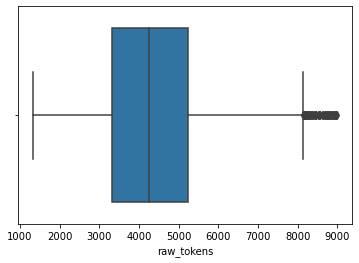

In [11]:
#Filtering out data that don't make sense
df_netflix_series = df_netflix_series[df_netflix_series['raw_tokens']>=1320] #in general lower tokens means corrupter data. with this i'm excluding cartoons by accident though
df_netflix_series = df_netflix_series[df_netflix_series['raw_tokens']<=9000] #around 800 transcripts out
df_netflix_series.reset_index(drop=True, inplace=True)
#Spotting outliers
q1, q3= np.percentile(df_netflix_series['raw_tokens'],[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
print('lower_bound: '+ str(lower_bound))
print('upper_bound: '+ str(upper_bound))

#interative boxplot
# import plotly_express as px
# import plotly.graph_objects as go
# from plotly.offline import iplot, init_notebook_mode

# df_netflix_series.dtypes
# fig = go.Figure()
# fig.add_box(x=df_netflix_series['raw_tokens'], text=df_netflix_series['season_episode_names'])
# iplot(fig)

#static boxplot
sns.boxplot(x=df_netflix_series['raw_tokens'])

### Randomizing samples

In [12]:
from sklearn.utils import shuffle
df_netflix_series = shuffle(df_netflix_series)
df_netflix_series.reset_index(drop=True, inplace=True)

In [13]:
#counting samples
df_netflix_series = df_netflix_series[['transcripts','titles', 'seasons', 'season_episodes', 'season_episode_names', 'imdb', 'original']]

title_count = []
for index, title in enumerate(df_netflix_series['titles']):
    subset = df_netflix_series.iloc[:index+1]
    count = len(subset[subset['titles'] == title])
    title_count.append(count)
    
df_netflix_series['count'] = title_count

### Picking only between 3 and 10 samples (episodes) per TV show

In [14]:
#7 series filtered with the raw_tokens previous analysis 
df_netflix_series_sample = df_netflix_series[(df_netflix_series['count']<10)]

### TV Shows to exclude later (they got less than 3 transcripts after filtering)

In [98]:
exclude_series = df_netflix_series_sample.groupby('titles').count().sort_values('transcripts')[:4].index.values

In [16]:
# cleaning transcripts
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)
df_netflix_series_sample['transcripts'] = df_netflix_series_sample['transcripts'].apply(round1)

/Applications/anaconda3/envs/scrapping/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
df_netflix_series_sample = df_netflix_series_sample.assign(tokens=df_netflix_series_sample['transcripts'].apply(lambda x:len(x.split())))

In [273]:
#Checking both dataframes have the same index for further 'concatenate'
df_netflix_series.loc[5016, 'season_episode_names']
df_netflix_series_sample.loc[5016, 'season_episode_names']

'S1E6: The D-Train to Bone Town'

## Exploratory Data Analysis

### Document-Term Matrix¶

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix = cv.fit_transform(df_netflix_series_sample['transcripts'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix, index=df_netflix_series_sample.index,
                                           columns=cv.get_feature_names())

In [50]:
df_dtm = df_dtm.T

### Formula

In [55]:
def get_frames(indices, dtm, thousand_level=None): #, thousand_level ['4'], ['5-14']
    """1. The df_dtm gives the number of times a word (all_forms) shows up in an episode/movie
       2. Then its joined to get the level and base_forms of each word
       3. The final df has the words counted for each episode so it can be seen base_forms repetition in the final df"""
    frames = []
    for index in indices:
        df_count_words = dtm[[index]].loc[dtm[index]!=0]
        df_count_words = df_count_words.reset_index()
        df_count_words.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        df_count_words_level = pd.merge(df_count_words, df_nation[['base_forms', 'all_forms',
                                'levels_frequency', 'levels', 'levels_coverage']], how='left', on='all_forms', indicator=True)
        df_count_words_level.loc[df_count_words_level['_merge']=='left_only', 'levels_coverage'] = 100
        if thousand_level is not None: #only consider words in specific levels
            df_count_words_level = df_count_words_level[df_count_words_level['levels_frequency'].isin(thousand_level)]
        frames.append(df_count_words_level)
    df_count_words_level = pd.concat(frames)
    return df_count_words_level


def get_coverage(indices, df_dtm):
    frames = []
    for episode_index in indices:
        df_coverage_episode = get_frames([episode_index], df_dtm) ##
        df_coverage_episode = df_coverage_episode[['count' ,'levels_coverage']].groupby('levels_coverage').sum()
        df_coverage_episode.drop([28, 29], axis=0, inplace=True, errors='ignore')
        df_coverage_episode['%'] = 100 * (round(df_coverage_episode['count']/
                                            df_coverage_episode['count'].sum(), 4))
        df_coverage_episode = df_coverage_episode.reset_index()
        condition = [(df_coverage_episode['levels_coverage']<=4),
            (df_coverage_episode['levels_coverage']>=5) & (df_coverage_episode['levels_coverage']<=15),
                    (df_coverage_episode['levels_coverage']>=26)] #15 includes list from 15 to 25
        values = [df_coverage_episode['levels_coverage'], 5, df_coverage_episode['levels_coverage']]
        df_coverage_episode['lvl'] = np.select(condition, values)
        df_coverage_episode = df_coverage_episode.groupby('lvl').sum()
        df_coverage_episode['cumulative'] = df_coverage_episode['%'].cumsum()
        if len(indices)==1:   
            df_coverage_episode = df_coverage_episode[['count', '%']].T.reset_index(drop=True)
        elif len(indices)>1:
            df_coverage_episode = df_coverage_episode[['%']].T.reset_index(drop=True)
            df_coverage_episode['index'] = episode_index
        frames.append(df_coverage_episode)
    return frames

In [56]:
frames = get_coverage(df_netflix_series_sample.index.values, df_dtm)

### Vocabulary coverage in all episodes

In [126]:
df_statistics = pd.concat(frames, axis=0, ignore_index=True)[['index', 1, 2, 3, 4, 5, 26, 27, 100]]
#fill na values in list 27
df_statistics[27.0].fillna(0, inplace=True)
#assume you know interjections, character names and words created in the tv series
df_statistics['Lvl 1'] = df_statistics[1] + df_statistics[26] + df_statistics[27] + df_statistics[100]
df_statistics['Lvl 1+2'] = df_statistics['Lvl 1'] + df_statistics[2]
df_statistics['Lvl 1+2+3'] = df_statistics['Lvl 1+2'] + df_statistics[3]
df_statistics['Lvl 1+2+3+4'] = df_statistics['Lvl 1+2+3'] + df_statistics[4]
df_statistics = pd.concat((df_netflix_series_sample[['season_episode_names', 'seasons', 'titles', 'original']], df_statistics.set_index('index')), axis=1)
df_statistics

,season_episode_names,seasons,titles,original,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4
0,S7E5: Go Getters,7,the walking dead,Catalog,89.86,2.43,0.62,0.52,1.59,3.02,1.25,0.69,94.82,97.25,97.87,98.39
1,S1E9: Bodem,1,undercover,Netflix,87.10,3.11,1.19,1.38,1.49,4.00,0.84,0.89,92.83,95.94,97.13,98.51
2,S1E5: Episode #1.5,1,flinch,Netflix,80.80,5.27,0.83,1.14,3.77,3.12,2.50,2.55,88.97,94.24,95.07,96.21
3,S2E1: The Man Who Saved Central City,2,the flash,Catalog,86.85,4.77,1.81,0.90,1.73,2.63,0.82,0.49,90.79,95.56,97.37,98.27
4,S5E1: My Bad,5,dexter,Catalog,89.61,3.10,0.82,0.47,1.85,3.10,0.87,0.17,93.75,96.85,97.67,98.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12366,S1E5: Over de grens,1,undercover,Netflix,88.46,3.17,1.02,0.97,1.71,2.25,0.70,1.72,93.13,96.30,97.32,98.29
12368,S1E4: C'est un beau moment,1,marianne,Netflix,86.89,4.08,1.55,1.84,1.96,2.00,0.29,1.39,90.57,94.65,96.20,98.04
12378,S1E5: The Maple Syrup Heist,1,dirty money,Netflix,81.77,5.52,2.24,3.01,4.36,1.52,0.00,1.57,84.86,90.38,92.62,95.63
12379,S1E4: Liza Treyger,1,the degenerates,Netflix,86.53,4.32,0.98,0.68,2.94,1.57,2.46,0.54,91.10,95.42,96.40,97.08


In [145]:
df_netflix_series_sample.groupby(['titles']).count()
df_titles = df_netflix_series_sample.groupby(['titles', 'original'], as_index=False).count()
df_titles

,titles,original,transcripts,seasons,season_episodes,season_episode_names,imdb,count,tokens
0,13 reasons why,Netflix,9,9,9,9,9,9,9
1,1994,Netflix,4,4,4,4,4,4,4
2,3,Netflix,9,9,9,9,9,9,9
3,45 rpm,Catalog,5,5,5,5,0,5,5
4,a series of unfortunate events,Netflix,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...
495,world war ii in colour,Catalog,9,9,9,9,0,9,9
496,wu assassins,Netflix,9,9,9,9,9,9,9
497,wynonna earp,Catalog,9,9,9,9,0,9,9
498,yeh meri family,Catalog,7,7,7,7,0,7,7


In [151]:
df_vocabulary_series = df_statistics.groupby('titles').mean().sort_values('Lvl 1', ascending=False)
#list 100 'unique words' shouldn't be greater than 5% (words used created or only used in that tv show)
df_vocabulary_series = df_vocabulary_series[df_vocabulary_series[100.0]<=3.5]
df_vocabulary_series = df_vocabulary_series[~df_vocabulary_series.index.isin(exclude_series)]
df_vocabulary_series = df_vocabulary_series.round(1)
df_vocabulary_series.reset_index(inplace=True)
df_vocabulary_series = pd.merge(df_vocabulary_series, df_titles[['titles', 'original']], on='titles')
df_vocabulary_series

,titles,seasons,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4,original
0,jinn,1.0,89.3,2.6,0.7,0.7,0.6,3.0,0.3,2.8,95.3,98.0,98.7,99.4,Netflix
1,bates motel,2.6,90.6,2.7,0.7,0.5,0.8,2.7,1.4,0.5,95.2,97.9,98.7,99.2,Catalog
2,good morning call,1.0,90.1,2.3,0.8,0.6,1.2,0.5,2.1,2.3,95.1,97.4,98.1,98.8,Netflix
3,tidelands,1.0,89.9,2.6,0.5,0.5,1.4,1.2,1.2,2.6,94.9,97.6,98.1,98.6,Netflix
4,easy,3.0,90.7,2.5,0.9,0.4,1.3,0.7,3.0,0.5,94.9,97.4,98.3,98.7,Netflix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,americas book of secrets,1.0,77.9,9.3,5.0,1.5,3.3,2.4,0.0,0.5,80.9,90.2,95.2,96.7,Catalog
468,ancient aliens,4.2,75.8,7.8,5.8,1.8,4.1,3.2,0.1,1.4,80.5,88.3,94.1,95.9,Catalog
469,the universe,1.2,78.3,8.2,4.6,2.9,4.0,1.2,0.0,0.8,80.3,88.4,93.0,96.0,Catalog
470,world war ii in colour,1.0,69.5,10.0,6.2,1.7,3.5,8.2,0.0,0.9,78.6,88.6,94.8,96.5,Catalog


### Filtering more transcripts 

In [283]:
#Apache the life of Tevez (TV show in Spanish)
exclude_show = df_vocabulary_series[df_vocabulary_series['titles']=='apache the life of carlos tevez'].index.values
df_vocabulary_series = df_vocabulary_series[~df_vocabulary_series.index.isin(exclude_show)]
df_vocabulary_series.reset_index(drop=True, inplace=True)

In [284]:
# Final Netflix Catalog
df_vocabulary_series.groupby('original').count()

,titles,seasons,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4
original,,,,,,,,,,,,,,
Catalog,248,248,248,248,248,248,248,248,248,248,248,248,248,248
Netflix,223,223,223,223,223,223,223,223,223,223,223,223,223,223


In [152]:
#Top and last 10
#Top 10
for i in df_vocabulary_series[df_vocabulary_series['original']=='Netflix'][:10].values:
    print(i[0].title()+','+str(i[11])+','+str(i[12])+','+str(i[13]))
#Last 10
for i in df_vocabulary_series[df_vocabulary_series['original']=='Netflix'][-10:].values:
    print(i[0].title()+','+str(i[11])+','+str(i[12])+','+str(i[13]))

Jinn,98.0,98.7,99.4
Good Morning Call,97.4,98.1,98.8
Tidelands,97.6,98.1,98.6
Easy,97.4,98.3,98.7
Black Summer,97.5,97.9,98.6
Summertime,97.3,98.1,98.4
Baby,97.7,98.5,98.9
Top Boy,97.2,97.9,98.3
Bloodline,97.4,98.3,98.8
The End Of The Fing World,97.6,98.4,98.8
Dirty Money,92.7,95.9,97.8
Ghost In The Shell Sac_2045,92.4,95.6,96.7
Spy Kids Mission Critical,92.0,94.1,95.4
Sugar Rush Christmas,92.0,93.6,94.8
Killer Ratings,93.2,96.6,97.9
Cooked,91.8,94.8,96.2
Rise Of Empires Ottoman,90.7,93.6,95.7
Rotten,91.4,95.2,96.9
Carmen Sandiego,90.4,93.7,95.3
Explained,90.2,95.0,96.1


In [287]:
#preparing data for ScatterPlot
df_1 = df_vocabulary_series[['Lvl 1', 'titles', 'original']]
df_1 = df_1.assign(label = 'Lvl 1')
df_1.rename(columns={'Lvl 1':'lvl'}, inplace=True)
df_2 = df_vocabulary_series[['Lvl 1+2', 'titles', 'original']]
df_2 = df_2.assign(label = 'Lvl 1+2')
df_2.rename(columns={'Lvl 1+2':'lvl'}, inplace=True)
df_3 = df_vocabulary_series[['Lvl 1+2+3', 'titles', 'original']]
df_3 = df_3.assign(label = 'Lvl 1+2+3')
df_3.rename(columns={'Lvl 1+2+3':'lvl'}, inplace=True)
# df_4 = df_vocabulary_series[['Lvl 1+2+3+4', 'season_episode_names']]
# df_4 = df_4.assign(label = 'Lvl 1+2+3+4')
# df_4.rename(columns={'Lvl 1+2+3+4':'lvl'}, inplace=True)
df_dot = pd.concat([df_1, df_2, df_3])
df_dot['lvl'] = df_dot['lvl'].apply(lambda x:round(x,1))
df_dot.reset_index(drop=True, inplace=True)

In [288]:
#creating ranking column
rank = df_dot.index.values
df_dot['rank'] = rank+1
df_dot.loc[df_dot['rank']>len(df_vocabulary_series), 'rank']='-'
df_dot

,lvl,titles,original,label,rank
0,95.3,jinn,Netflix,Lvl 1,1
1,95.2,bates motel,Catalog,Lvl 1,2
2,95.1,good morning call,Netflix,Lvl 1,3
3,94.9,tidelands,Netflix,Lvl 1,4
4,94.9,easy,Netflix,Lvl 1,5
...,...,...,...,...,...
1408,95.2,americas book of secrets,Catalog,Lvl 1+2+3,-
1409,94.1,ancient aliens,Catalog,Lvl 1+2+3,-
1410,93.0,the universe,Catalog,Lvl 1+2+3,-
1411,94.8,world war ii in colour,Catalog,Lvl 1+2+3,-


In [290]:
title_count = []
for index, percentage in enumerate(df_dot['lvl']):
    subset = df_dot.iloc[:index+1]
    count = len(subset[subset['lvl']==percentage])
    title_count.append(count)

df_dot['count'] = title_count

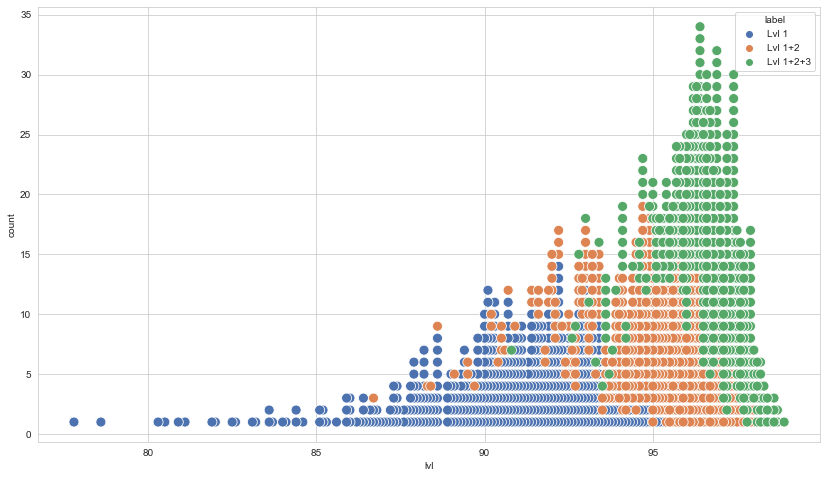

In [291]:
#static scatterplot seaborn
from matplotlib import pyplot as plt
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 8))
ax = sns.scatterplot(x='lvl', y='count', data=df_dot,
             hue='label', s=100, ax=ax, palette="deep")

# data for DataWrapper
# for i in df_dot.values:
#     print(i[1].title() + ', ' + str(i[0]) + ', ' + str(i[3]) +', ' + str(i[2])+', '+ str(i[4])+','+str(i[5]))

### Top 10 Originals

In [204]:
for i in df_vocabulary_series[df_vocabulary_series['original']=='Netflix'][:10].values:
    print(i[0].title())

Jinn
Good Morning Call
Tidelands
Easy
Black Summer
Summertime
Baby
Top Boy
Bloodline
The End Of The Fing World


### Notes

In [293]:
#Ups and downs in episodes from some TV shows
#There are episodes that have less than 3.5% in average but on individual episodes have 9% like the walking dead (1 outlier)
df_netflix_series_sample[df_netflix_series_sample['titles'].str.contains('walking dead')]
df_statistics[df_statistics['titles'].str.contains('walking dead')] #check

#The analysis gives a good idea of the level of most TV shows, but a couple of them MIGHT behave differently

,season_episode_names,seasons,titles,original,1.0,2.0,3.0,4.0,5.0,26.0,27.0,100.0,Lvl 1,Lvl 1+2,Lvl 1+2+3,Lvl 1+2+3+4
0,S7E5: Go Getters,7,the walking dead,Catalog,89.86,2.43,0.62,0.52,1.59,3.02,1.25,0.69,94.82,97.25,97.87,98.39
71,S4E11: Claimed,4,the walking dead,Catalog,82.44,2.83,0.88,0.34,1.72,2.05,0.63,9.12,94.24,97.07,97.95,98.29
86,S2E6: Secrets,2,the walking dead,Catalog,88.65,2.58,1.07,1.45,1.16,2.52,0.85,1.70,93.72,96.30,97.37,98.82
89,S2E3: Save the Last One,2,the walking dead,Catalog,88.06,2.40,0.29,1.56,1.77,2.86,0.67,2.40,93.99,96.39,96.68,98.24
171,S2E9: Triggerfinger,2,the walking dead,Catalog,89.31,2.27,0.22,0.96,1.48,3.03,0.86,1.88,95.08,97.35,97.57,98.53
347,S7E11: Hostiles and Calamities,7,the walking dead,Catalog,86.18,4.15,1.20,1.26,3.27,1.32,1.23,1.41,90.14,94.29,95.49,96.75
370,S4E2: Infected,4,the walking dead,Catalog,90.09,3.27,0.97,0.69,1.57,2.44,0.65,0.32,93.50,96.77,97.74,98.43
386,S10E5: What It Always Is,10,the walking dead,Catalog,86.70,4.45,1.07,0.81,2.90,1.14,1.76,1.18,90.78,95.23,96.30,97.11
858,S1E2: Guts,1,the walking dead,Catalog,87.57,4.02,0.90,0.66,2.90,1.53,1.96,0.47,91.53,95.55,96.45,97.11


In [292]:
#comparing levels
# list_1 = df_vocabulary_series.sort_values(1.0, ascending=False)[:100].index.values
# list_2 = df_vocabulary_series.sort_values('Lvl 1', ascending=False)[:100].index.values

# i = [i for i in list_1 if i in list_2]
# len(i)